In [2]:
import math 
import numpy as np
import matplotlib.pyplot as plt
from csv import reader
import os
import pandas as pd
import matplotlib.transforms as mtransforms
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, to_rgb
from matplotlib.widgets import AxesWidget, CheckButtons, RadioButtons, Slider
from scipy.interpolate import interp1d
import time 

In [85]:
global laplines, checkbtn, plotter, LINE_WIDTH, LINE_ALPHA, LINE_COLOR
def init_track_data(track = 'vallelunga',folder="Data",plot=False):
    TRACK = track

    FOLDER = folder


    FOLDER = FOLDER + "/" + TRACK



    DISPLAY_ONLY_FULL_LAPS = True       # display only full laps, from checker flag line to checker flag line (can be a valid or not lap)
    DISPLAY_LAP_TIME = False             # display the lap time in the command line interface
    HIDE_ALL_NOT_BEST_OR_WORST = True   # plot only the best and worst lap, other laps can be displayed with the checkbuttons
    DISPLAY_ONLY_LAP_DELTA_MAX = 0    # filter out laps with a delta time over the defined value in seconds, set to 0 for no filtering

    # Display Modes
    DISPLAY_MODE_LAPTIME = 0
    DISPLAY_MODE_PEDALS = 1
    DISPLAY_MODE_VELOCITY = 2
    DISPLAY_MODE_CURVATURE = 3
    DISPLAY_MODE_VELOCITY_PLOT = 4
    DISPLAY_MODE_G_PLOT = 5
    DISPLAY_MODE_TRAJ_DIST = 6
    DISPLAY_MODE_VELOC_ANGLE = 7
    DISPLAY_MODE_TIRE_SLIP_ANGLE = 8
    DISPLAY_MODE_TIRE_SLIP_RATIO = 9
    DISPLAY_MODE_LIDAR = 10


    DISPLAY_MODE = DISPLAY_MODE_PEDALS



    CIRCUIT_LIMIT_X = 560       # in meters     560 for Vallelunga
    CIRCUIT_LIMIT_Y = 195       # in meters     195 for Vallelunga
    CIRCUIT_ROTATION = 0     # in degrees   -57° for Vallelunga
    CIRCUIT_TRANSLATE_X = 0     # in meters       0 for Vallelunga
    CIRCUIT_TRANSLATE_Y = 0    # in meters       0 for Vallelunga

    LINE_WIDTH = 2.0              # default plot line width
    LINE_ALPHA = 0.3              # default plot line transparency (alpha)
    LINE_COLOR = (0.3, 0.3, 1.0)  # default plot line color in RGB


    dir_path = os.path.dirname(os.path.realpath('lidar.py'))
    input_path = dir_path + "/" + FOLDER + "/"
    track_path = dir_path + "/" + TRACK + "/"

    trajectories = []
    valid_trajectories = []
    valid_tp_trajectories = []
    filename_array = []
    laplines = []

    track_data = []
    track_length = 0
    track_filename = TRACK + ".csv"

    # arrays of 3D world coordinate frame vertors
    centerline_xyz = []
    sideleft_xyz = []
    sideright_xyz = []

    # arrays of 2D projected world coordinate frame vertors   (x2d = x3d   y2d = - z3d)
    centerline_xy = []
    sideleft_xy = []
    sideright_xy = []



    # Load track data 
    # 20
    #['Position_X', 'Position_Y', 'Position_Z', 'Length', 'SideLeft', 'SideRight', 'Radius', 'Speed', 'Brake', 'Camber', 'Direction', 'Grade', 
    # 'Normal_X', 'Normal_Y', 'Normal_Z', 'Forward_X', 'Forward_Y', 'Forward_Z', 'Tag', 'LagG_Obsolete']
    if os.path.exists(track_path + track_filename):
        first_line = True
        array_size = 0
    
        with open(track_path + track_filename, newline='') as csvfile:
            csvreader = reader(csvfile, delimiter=',', quotechar='"', skipinitialspace=True)
        
            for line in csvreader:
                if first_line:
                    array_size = len(line)
                    first_line = False
                else:
                    data = []
                    for i in range(array_size):
                        data.append(float(line[i]))
                    
                    track_data.append(data)

        # add "NormalizedSplinePosition"
        #['Position_X', 'Position_Y', 'Position_Z', 'NormalizedSplinePosition', 'Length', 'SideLeft', 'SideRight', 'Radius', 'Speed', 'Brake', 'Camber',  
        # 'Direction', 'Grade', 'Normal_X', 'Normal_Y', 'Normal_Z', 'Forward_X', 'Forward_Y', 'Forward_Z', 'Tag', 'LagG_Obsolete']
    
        track_data = np.array(track_data)
        track_length = track_data[-1,3]
    
        if track_length <= 0.0:
            track_length = 1.0
    
        nsp_column = track_data[:, 3] / track_length
        track_data = np.insert(track_data, 3, nsp_column, axis=1)
    
        #compute and SideLeft XYZ and SideRight XYZ
        centerline_xyz = track_data[:, 0:3]
        normal_xyz =  track_data[:, 13:16]
        forward_xyz = track_data[:, 16:19]
        side_dir = np.cross(normal_xyz, forward_xyz)
        norms = np.linalg.norm(side_dir, axis=1)[np.newaxis] 
        normalized_side_dir = side_dir / norms.T
        '''
        print (centerline_xyz)
        print("----------")
        print (normal_xyz)
        print("----------")
        print (forward_xyz)
        print("----------")
        print (side_dir)
        print("----------")
        print (normalized_side_dir)
        '''
    
        sideleft_xyz = centerline_xyz + normalized_side_dir * track_data[:, 5][np.newaxis].T
        sideright_xyz = centerline_xyz + normalized_side_dir * -track_data[:, 6][np.newaxis].T
    

    
        # project 3D coordinates arrays into 2D coordinates
        centerline_xy = np.delete(centerline_xyz, obj=1, axis=1)
        centerline_xy[:,1] *= -1
        sideleft_xy = np.delete(sideleft_xyz, obj=1, axis=1)
        sideleft_xy[:,1] *= -1
        sideright_xy = np.delete(sideright_xyz, obj=1, axis=1)
        sideright_xy[:,1] *= -1
    if plot:
        df= pd.read_excel('test_PID.xlsx')
        df_rl = pd.read_excel('test.xlsx')
        df = df.sort_values(by='spline_position')
        df.speedKmh = 1 - np.abs(df_rl.speedKmh-df.speedKmh)/df.speedKmh
        positions =[]
        for i in range(df.shape[0]):
            temp=df.position[i].replace(' ','').replace('[','').replace(']','').split(',')
            temp_list=[]
            for idx,j in enumerate(temp):
                value=float(j)
                if idx== 2:
                    value*=-1
            
                temp_list.append(value)
            positions.append(temp_list)
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot()

        tr = mtransforms.Affine2D().rotate_deg(CIRCUIT_ROTATION).translate(CIRCUIT_TRANSLATE_X, CIRCUIT_TRANSLATE_Y) + ax.transData
        
        scatter =ax.scatter(list(zip(*positions))[0], list(zip(*positions))[2], c=df.speedKmh, marker="o", s=10*(72./fig.dpi)**2, transform=tr)
        ax.scatter(sideleft_xy[:,0], sideleft_xy[:,1], c="r", marker="o", s=0.2*(72./fig.dpi)**2, transform=tr,label='left side')
        ax.scatter(sideright_xy[:,0], sideright_xy[:,1], c="b", marker="o", s=0.2*(72./fig.dpi)**2, transform=tr,label='right side')
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower right", title="Speed difference")
        ax.add_artist(legend1)
        ax.legend()
        ax.set_title('Speed ratio between Human Expert and RL agent')
        plt.show()
    return df,df_rl

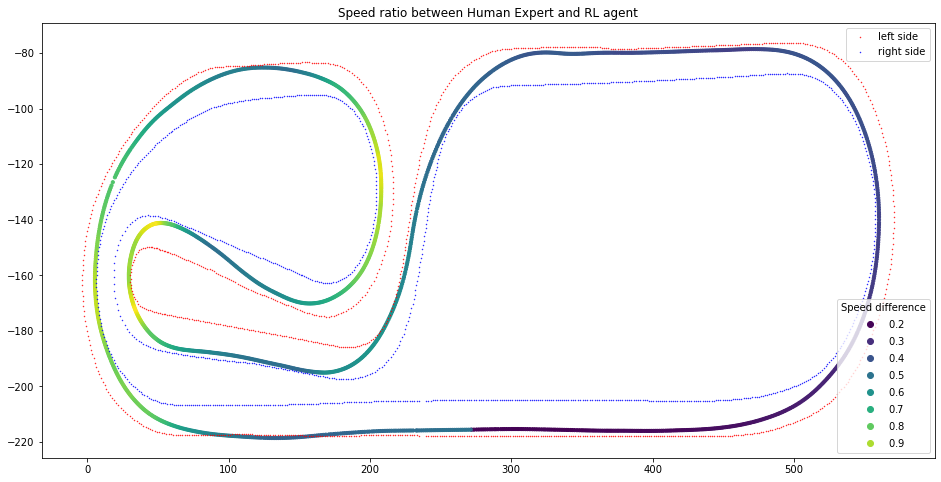

In [86]:
df,df_rl = init_track_data(track = 'vallelunga',folder="Data",plot=True)

In [35]:
(df_rl.speedKmh - df.speedKmh).dropna()

0       -80.948769
2       -81.091499
4       -81.179749
6       -81.244621
8       -81.310638
           ...    
3442   -128.417891
3444   -128.479523
3446   -128.524296
3448   -128.617737
3450   -128.945791
Name: speedKmh, Length: 1726, dtype: float64

In [64]:
test =df_rl.dropna()